# Plot curvature profile and velocity

# Setup

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import default_config as config
import torch
import train
import viz

import neuralgeom.datasets.utils as utils

import neuralgeom.models.neural_vae as neural_vae

INFO:root:Using pytorch backend


# Get config

In [10]:
run_id = "68de58a0"

CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)

Config in directory: /home/nmiolane/code/neuralgeom/neuralgeom/results/configs:
run_68de58a0_experimental_34_other_gain.json


In [11]:
with open(
    os.path.join(
        CONFIG_DIR, f"run_{run_id}_experimental_41_gain_1.json"
    ),
    "r",
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

FileNotFoundError: [Errno 2] No such file or directory: '/home/nmiolane/code/neuralgeom/neuralgeom/results/configs/run_68de58a0_experimental_41_gain_1.json'

# Get data and curvature profile

In [50]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_times_timestep1000000.txt! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep1000000.npy! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_labels_timestep1000000.txt! Loading...


The dataset transitions between two gains: 1.769000 and 1.000000.
We select gain 1: gain = 1.
Dataset shape: (99, 12).


(array([5., 3., 1., 1., 0., 1., 0., 0., 0., 1.]),
 array([0.06867082, 0.12112213, 0.17357343, 0.22602475, 0.27847606,
        0.33092734, 0.38337865, 0.43582997, 0.48828125, 0.54073256,
        0.59318388]),
 <BarContainer object of 10 artists>)

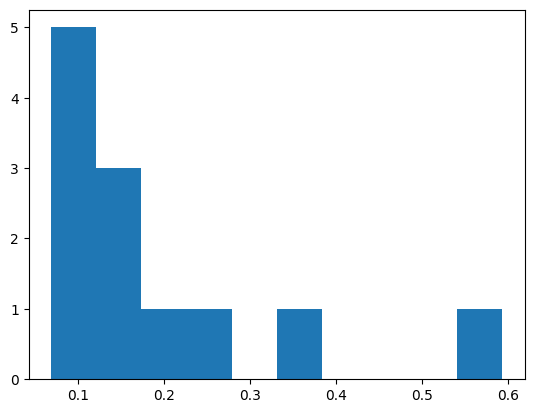

In [97]:
plt.hist(dataset_torch.mean(axis=0).cpu().numpy())

In [51]:
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.0
2,2,2.400831e+09,229.646926,6.372364,1.0
3,3,2.401831e+09,241.624300,17.123473,1.0
4,4,2.402831e+09,269.453404,32.549442,1.0
6,6,2.404831e+09,292.479285,26.062543,1.0
...,...,...,...,...,...
208,208,2.606831e+09,91.962998,17.013367,1.0
209,209,2.607831e+09,111.077788,23.476131,1.0
210,210,2.608831e+09,138.772454,30.795640,1.0
211,211,2.609831e+09,174.112722,34.613053,1.0


mean: 4423.04993948913
median: 1841.6703281152672
std: 7394.94572619993
min: 371.0531413781509
max: 45238.59142941933


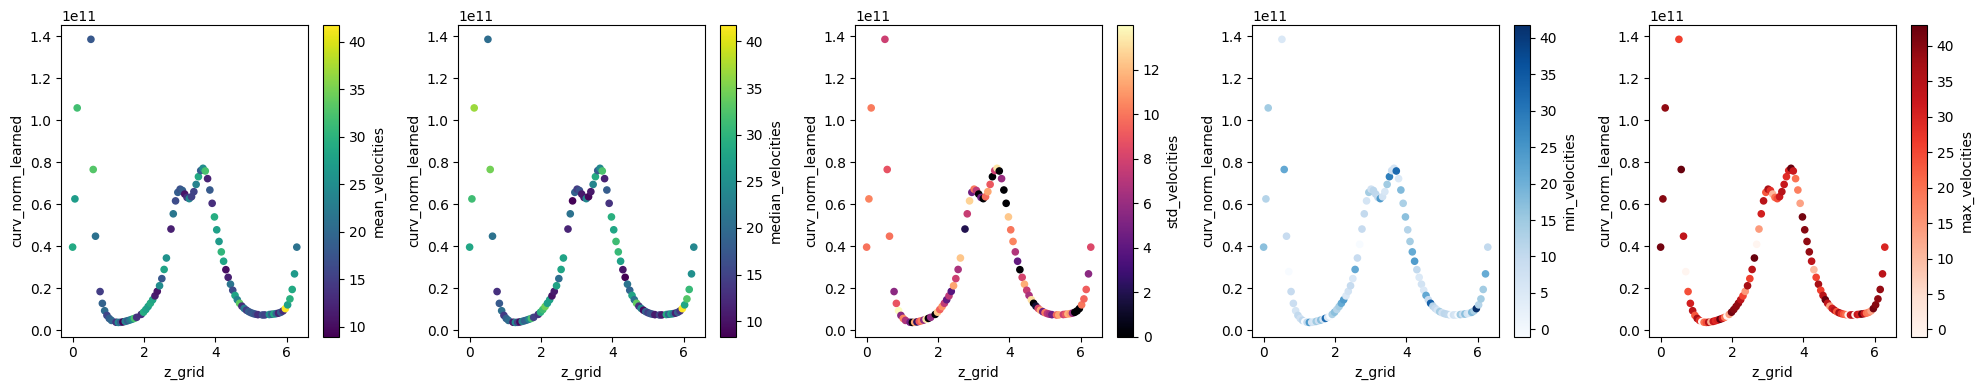

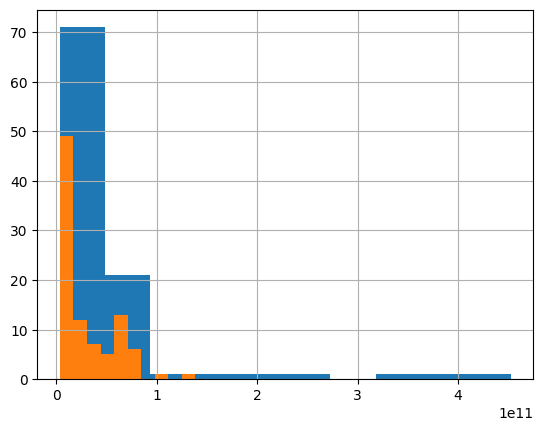

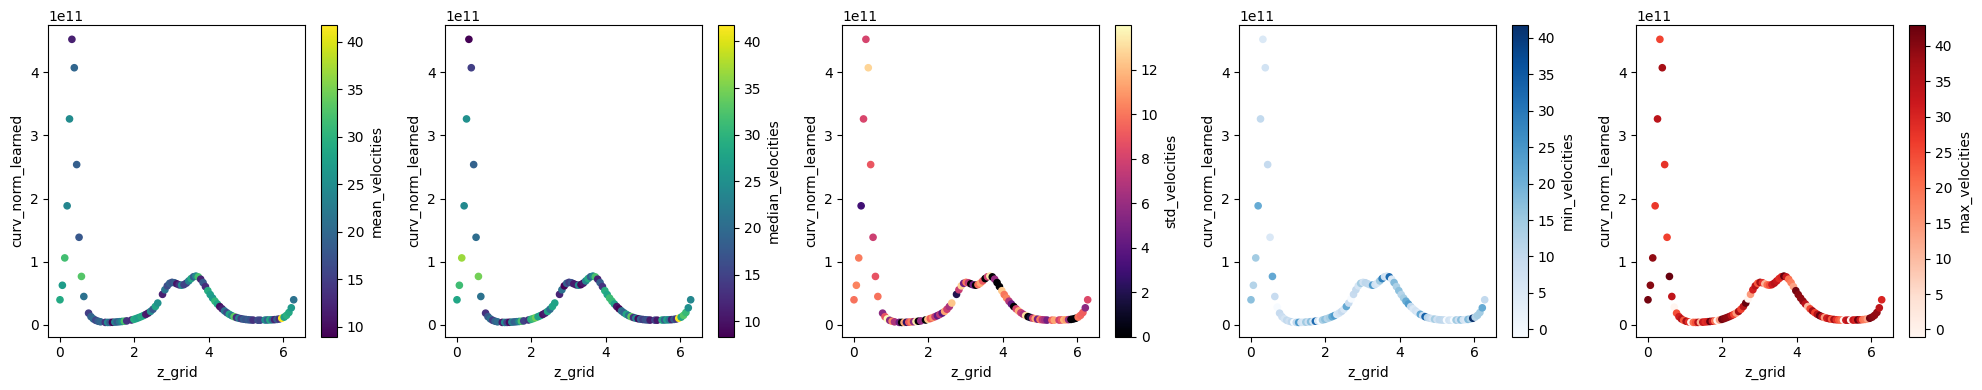

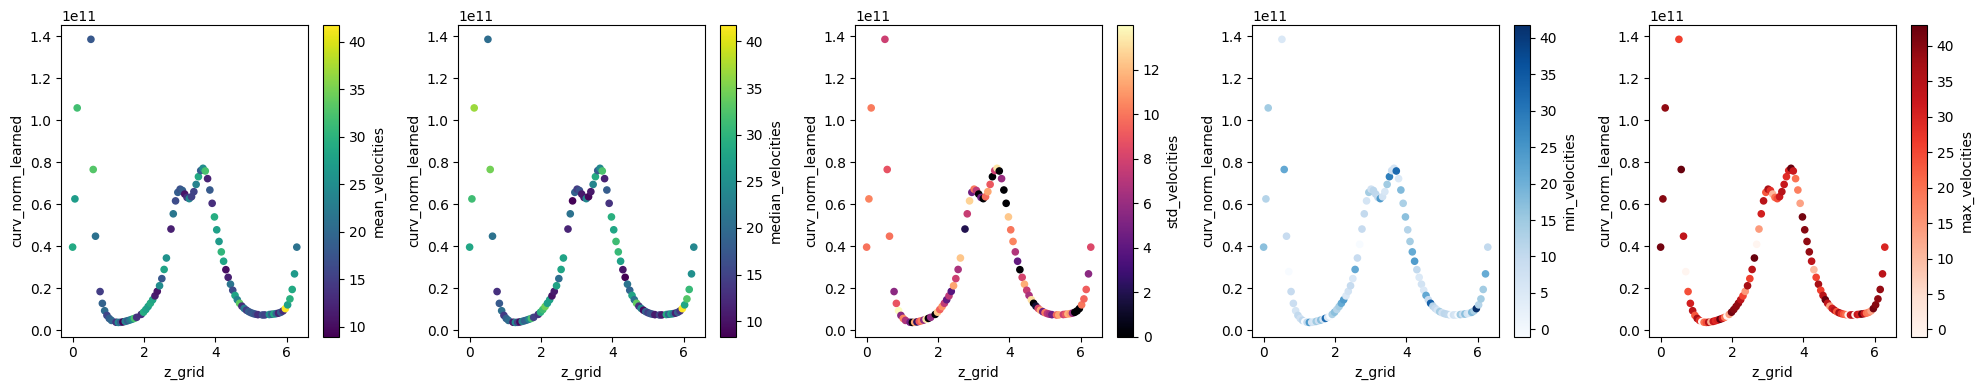

In [68]:
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

curv_norm_learned_profile = pd.read_csv(
    os.path.join(CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"))

curv_norm_learned_profile["curv_norm_learned"].hist()

median = curv_norm_learned_profile["curv_norm_learned"].median()
filtered = curv_norm_learned_profile[curv_norm_learned_profile["curv_norm_learned"] < 8 * median]
filtered["curv_norm_learned"].hist()


print("mean:", curv_norm_learned_profile["curv_norm_learned"].mean()/10000000)
print("median:", curv_norm_learned_profile["curv_norm_learned"].median()/10000000)
print("std:", curv_norm_learned_profile["curv_norm_learned"].std()/10000000)
print("min:", curv_norm_learned_profile["curv_norm_learned"].min()/10000000)
print("max:", curv_norm_learned_profile["curv_norm_learned"].max()/10000000)
viz.plot_curvature_velocities(curv_norm_learned_profile, config, labels)
viz.plot_curvature_velocities(filtered, config, labels)

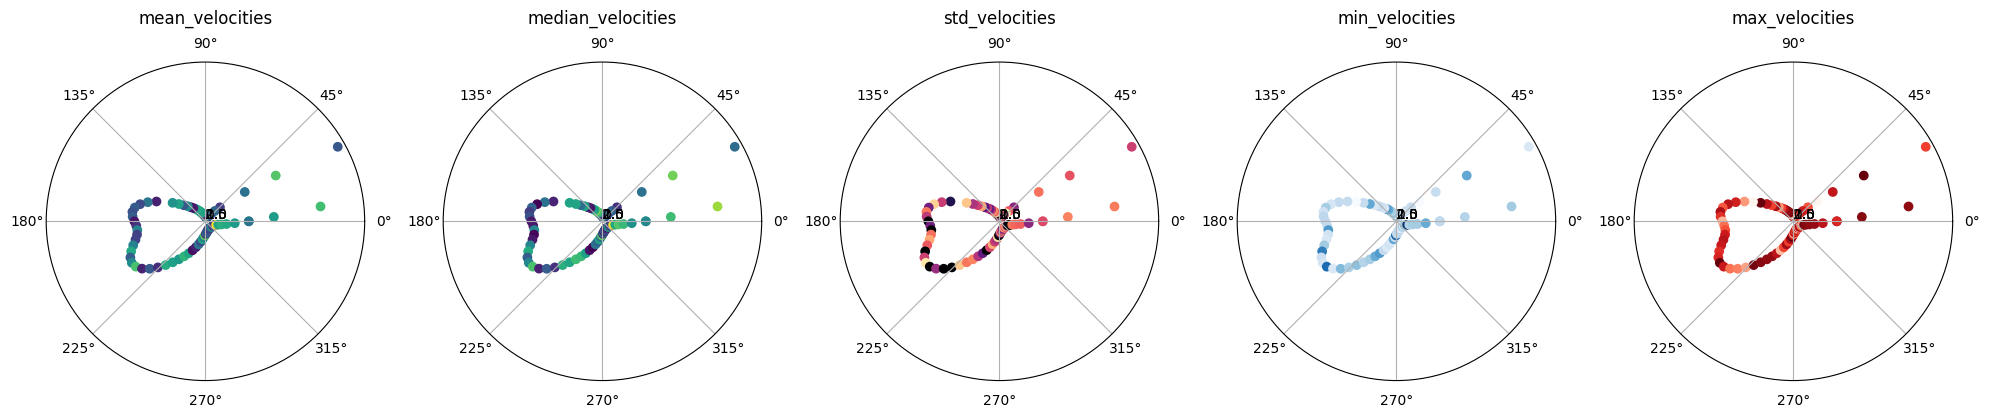

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

stats = ["mean_velocities", "median_velocities", "std_velocities", "min_velocities", "max_velocities"]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(nrows=1, ncols=len(stats), figsize=(20, 4), subplot_kw={'projection': 'polar'})
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    ax.scatter(filtered["z_grid"], filtered["curv_norm_learned"], c= filtered[stat_velocities], cmap=cmaps[i_stat])
    ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_title(stat_velocities, va='bottom')
fig.tight_layout()

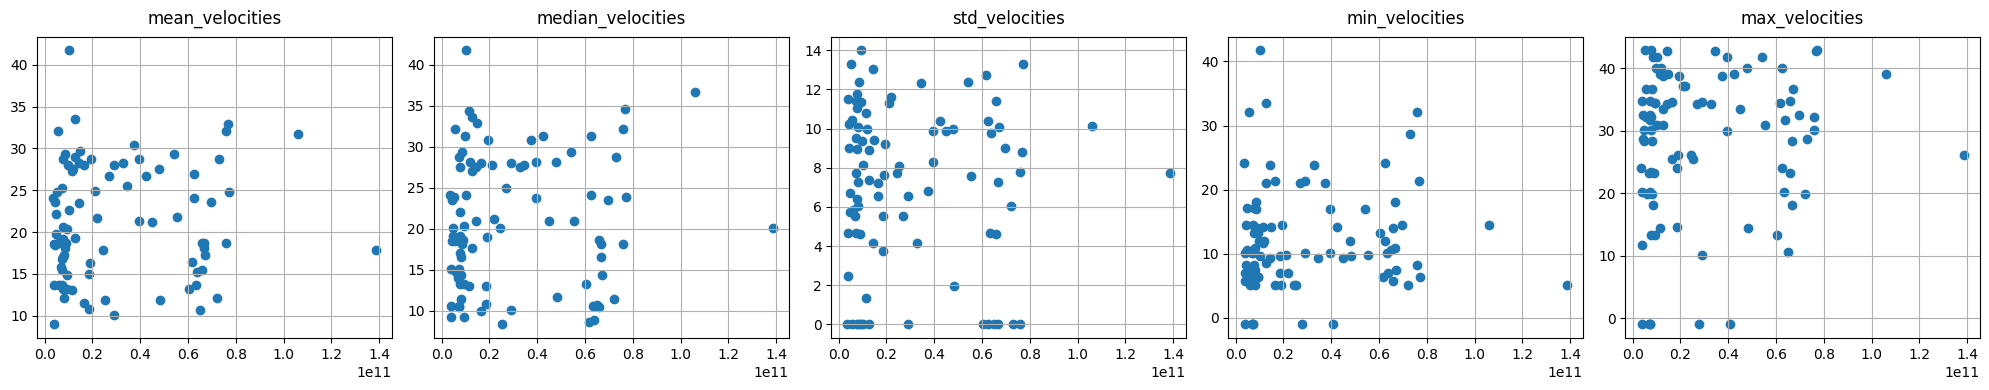

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=len(stats), figsize=(20, 4))
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    ax.scatter(filtered["curv_norm_learned"], filtered[stat_velocities], cmap=cmaps[i_stat])
    ax.grid(True)
    ax.set_title(stat_velocities, va='bottom')
fig.tight_layout()